# Predict using minimal data to show true demand

prepare a model that will use only arrival rates and aspirational targes for ED

Inputs
- A series of times in the day at which we want to make these predictions is set 
- A series of dates on which we want to make these predictions
- A time window after the prediction time, within which we are interested in predicting a number of patients (eg 8 hours)

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work' 


import patientflow

In [3]:
data_path= USER_ROOT / 'patientflow' / 'data-public'

In [4]:
import numpy as np
seed_path = USER_ROOT / 'seed' 
    # Read the seed from a saved file
with open(seed_path, 'r') as file:
    seed = int(file.read().strip())
# Set the seed for numpy
np.random.seed(seed=seed)
n = np.random.randint(1, 10*52)  


## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [5]:
uclh = True

In [6]:

from patientflow.load import set_file_paths
from patientflow.load import load_config_file

# set file locations
data_folder_name = 'data-raw-uclh' if uclh else 'data-public'
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        train_dttm = None, data_folder_name = data_folder_name, uclh = uclh, from_notebook=True, inference_time = False)

# load params
params = load_config_file(config_path)

prediction_times = params["prediction_times"]
start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
epsilon = float(params["epsilon"])
yta_time_interval = params["yta_time_interval"]

Configuration will be loaded from: /home/jovyan/work/patientflow/config-uclh.yaml
Data files will be loaded from: /home/jovyan/work/patientflow/data-raw-uclh
Trained models will be saved to: /home/jovyan/work/patientflow/trained-models
Images will be saved to: /home/jovyan/work/patientflow/notebooks/img


In [7]:
if uclh:
    media_file_path_weekdays = media_file_path / 'true-demand-uclh' / 'weekdays'
    media_file_path_weekends = media_file_path / 'true-demand-uclh' / 'weekends'
else:
    media_file_path_weekdays = media_file_path / 'true-demand' / 'weekdays'
    media_file_path_weekends = media_file_path / 'true-demand' / 'weekends'
    
media_file_path_weekdays.mkdir(parents=True, exist_ok=True)
media_file_path_weekends.mkdir(parents=True, exist_ok=True)


## Load data

In [8]:
import pandas as pd
from patientflow.load import set_data_file_names
from patientflow.load import data_from_csv

if uclh:
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_data_file_names(uclh, data_file_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_data_file_names(uclh, data_file_path)

inpatient_arrivals = pd.read_csv(yta_csv_path)
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)
inpatient_arrivals.set_index('arrival_datetime', inplace=True)


weekdays = inpatient_arrivals[inpatient_arrivals.index.weekday < 5]
weekends = inpatient_arrivals[inpatient_arrivals.index.weekday >= 5]


In [9]:
# summarise
print(f"Weekday dates span {weekdays.index.date.min()} to {weekdays.index.date.max()}")
print(f"Weekend dates span {weekends.index.date.min()} to {weekends.index.date.max()}")



Weekday dates span 2022-02-01 to 2024-02-29
Weekend dates span 2022-02-05 to 2024-02-25


## Get arrival rates by hour

Calculating time-varying arrival rates for data provided, which spans 543 unique dates
Calculating time-varying arrival rates for data provided, which spans 216 unique dates


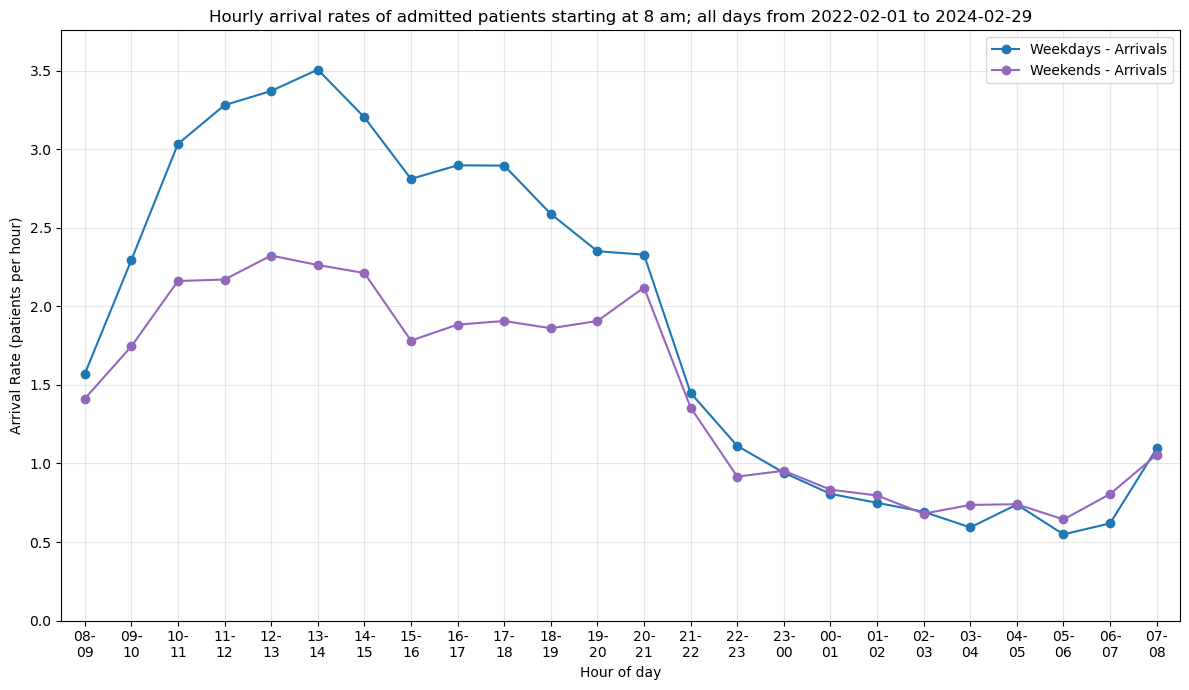

In [59]:
from patientflow.viz.arrival_rates import plot_arrival_rates, plot_dual_arrival_rates
from datetime import timedelta
start_plot_index = 8

# # plot for weekdays
# title = f'Hourly arrival rates of admitted patients starting at {start_plot_index} am; weekdays from {weekdays.index.date.min()} to {weekdays.index.date.max()}'
# plot_arrival_rates(weekdays, 
#                    title, 
#                    time_interval=60, 
#                    start_plot_index=start_plot_index, 
#                    file_prefix = '1_',
#                    media_file_path=media_file_path_weekdays)

# # plot for weekends
# title = f'Hourly arrival rates of admitted patients starting at {start_plot_index} am; weekends from {weekends.index.date.min()} to {weekends.index.date.max()}'
# plot_arrival_rates(weekends, 
#                    title, 
#                    time_interval=60, 
#                    start_plot_index=start_plot_index, 
#                    file_prefix = '1_',
#                    media_file_path=media_file_path_weekends
#                    )


# plot for both
title = f'Hourly arrival rates of admitted patients starting at {start_plot_index} am; all days from {inpatient_arrivals.index.date.min()} to {inpatient_arrivals.index.date.max()}'
plot_dual_arrival_rates(inpatient_arrivals_1=weekdays,
                        inpatient_arrivals_2=weekends, 
                    labels=('Weekdays', 'Weekends'),
                   title=title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '1_',
                   media_file_path=media_file_path_weekends
                   )

Calculating time-varying arrival rates for data provided, which spans 543 unique dates
Calculating time-varying arrival rates for data provided, which spans 543 unique dates


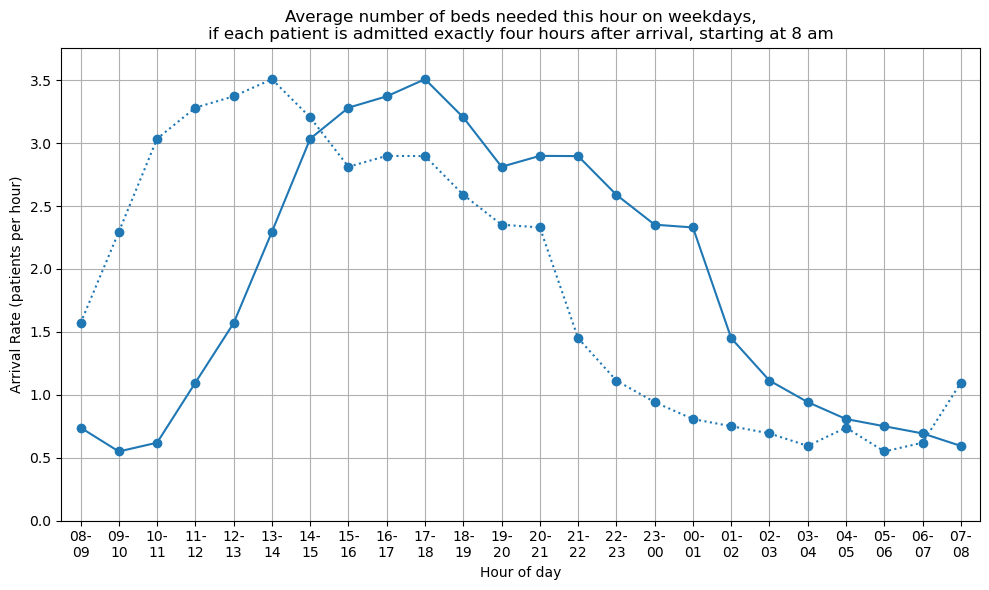

Calculating time-varying arrival rates for data provided, which spans 216 unique dates
Calculating time-varying arrival rates for data provided, which spans 216 unique dates


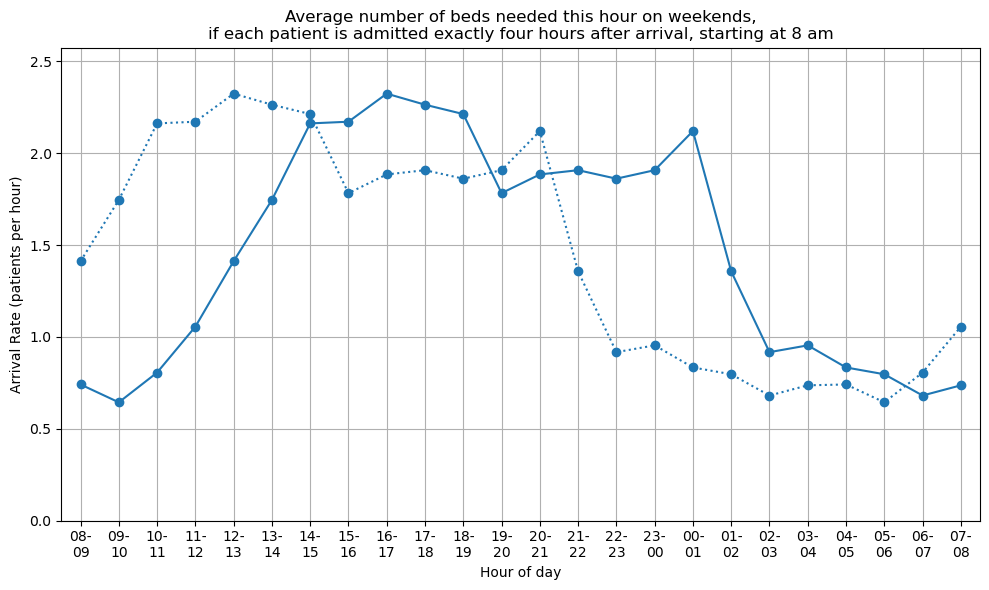

In [45]:
title = 'Average number of beds needed this hour on weekdays,\nif each patient is admitted exactly four hours after arrival, starting at 8 am'
plot_arrival_rates(weekdays,
                   title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '2_', 
                   lagged_by=4,
                    media_file_path=media_file_path_weekdays
)

title = 'Average number of beds needed this hour on weekends,\nif each patient is admitted exactly four hours after arrival, starting at 8 am'
plot_arrival_rates(weekends,
                   title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '2_', 
                   lagged_by=4,
                    media_file_path=media_file_path_weekends
)

In [14]:
start_of_influencable_window = 8
end_of_influencable_window = 17

## Plot cumulative arrival rates with or without line

In [15]:
scenarios = [
    {
        'data': weekdays,
        'path_suffix': 'weekdays',
        'label': 'weekdays'
    },
    {
        'data': weekends,
        'path_suffix': 'weekends',
        'label': 'weekends'
    }
]

scenario = scenarios[0]
title = f'Cumulative number of beds needed on {scenario["label"]}, by hour of the day,\n if each incoming patient is admitted exactly four hours after arrival, starting at 8 am'
# plot_cumulative_arrival_rates(
#     scenario['data'],
#     title,
#     start_plot_index=8,
#     media_file_path=f"{media_file_path}_{scenario['path_suffix']}",
#     file_prefix='3_'
# )
f"{media_file_path}/{scenario['path_suffix']}"


'/home/jovyan/work/patientflow/notebooks/img/weekdays'

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


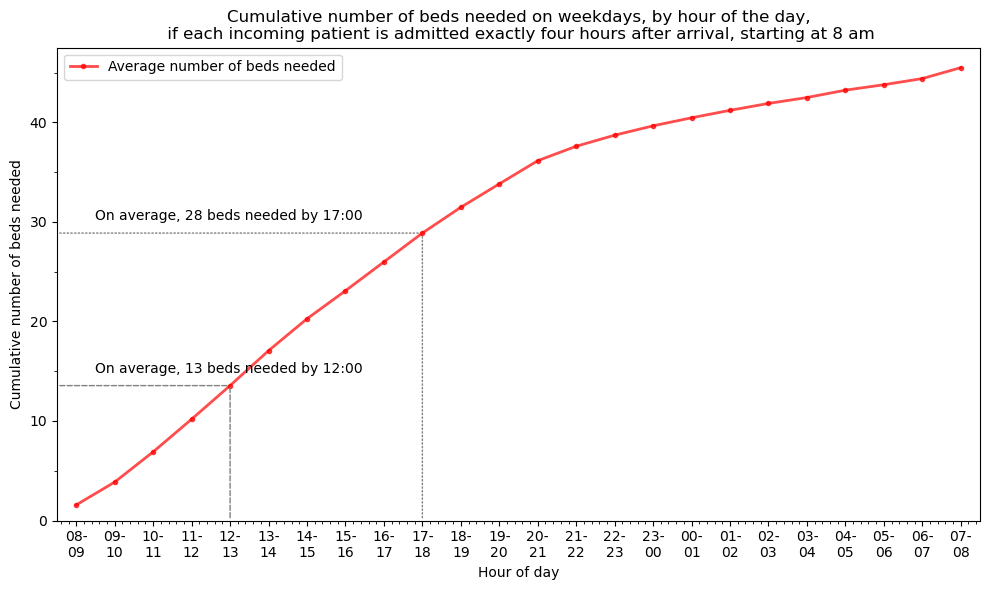

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


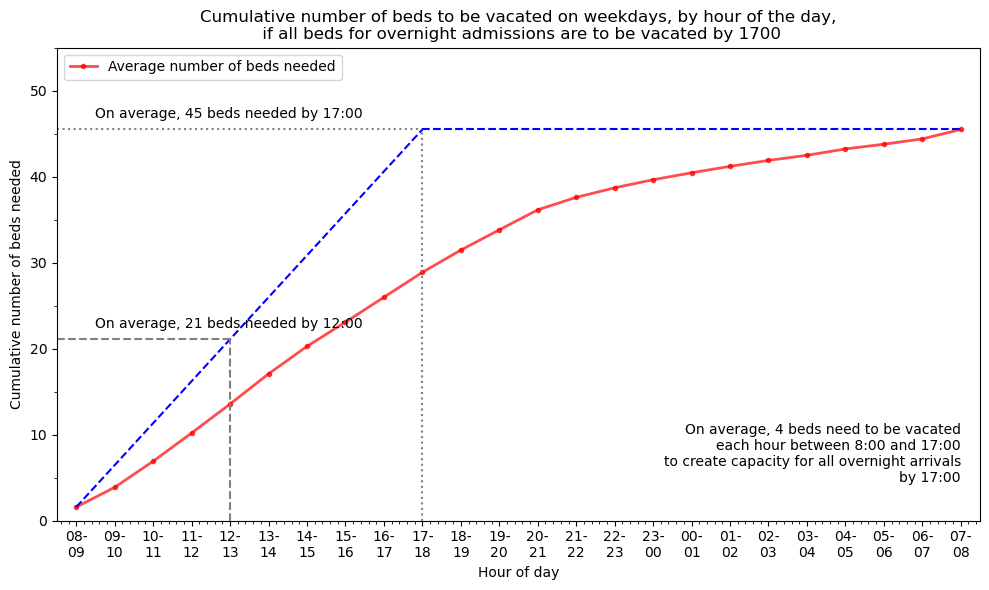

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


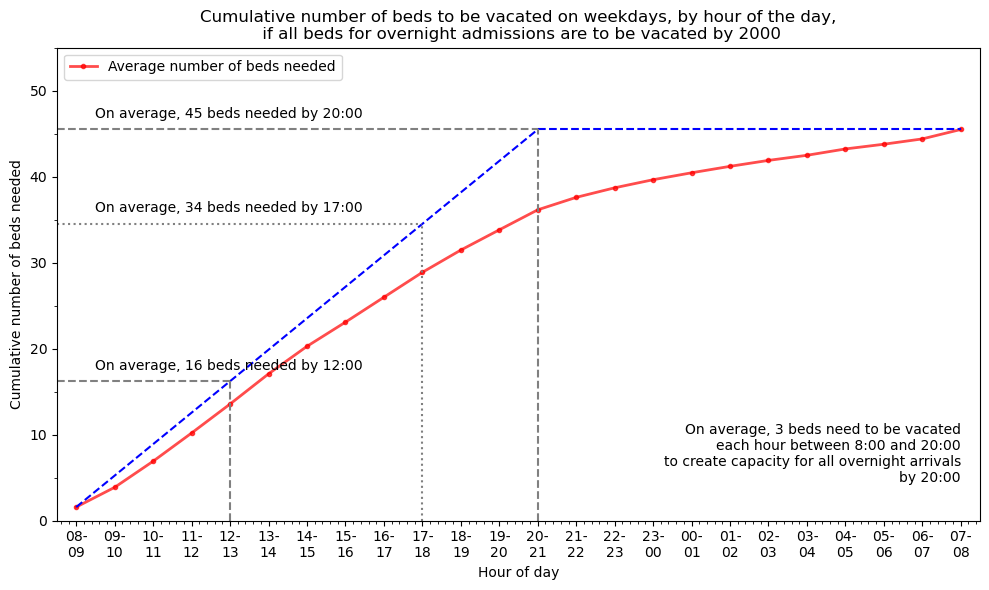

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


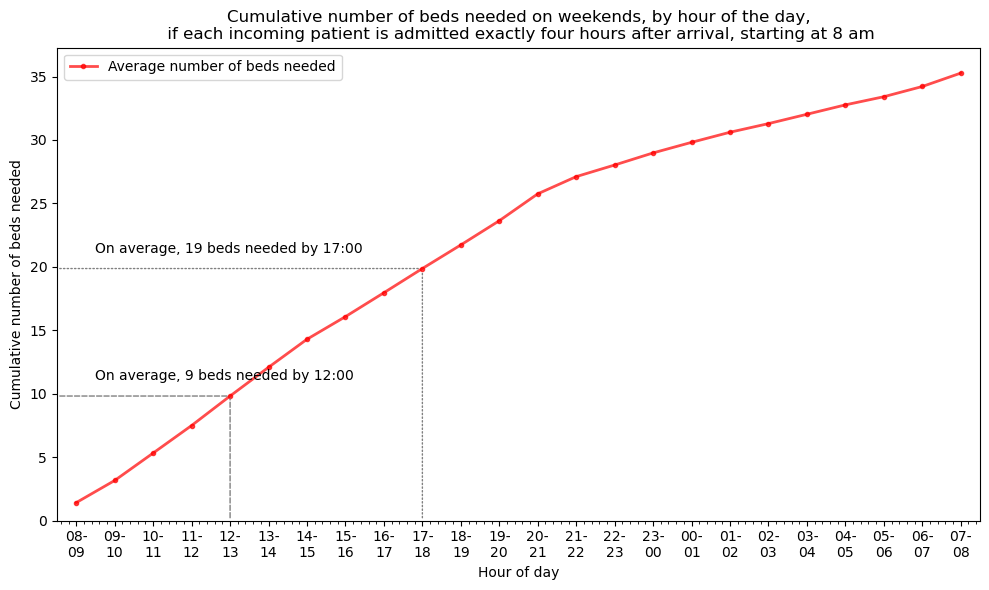

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


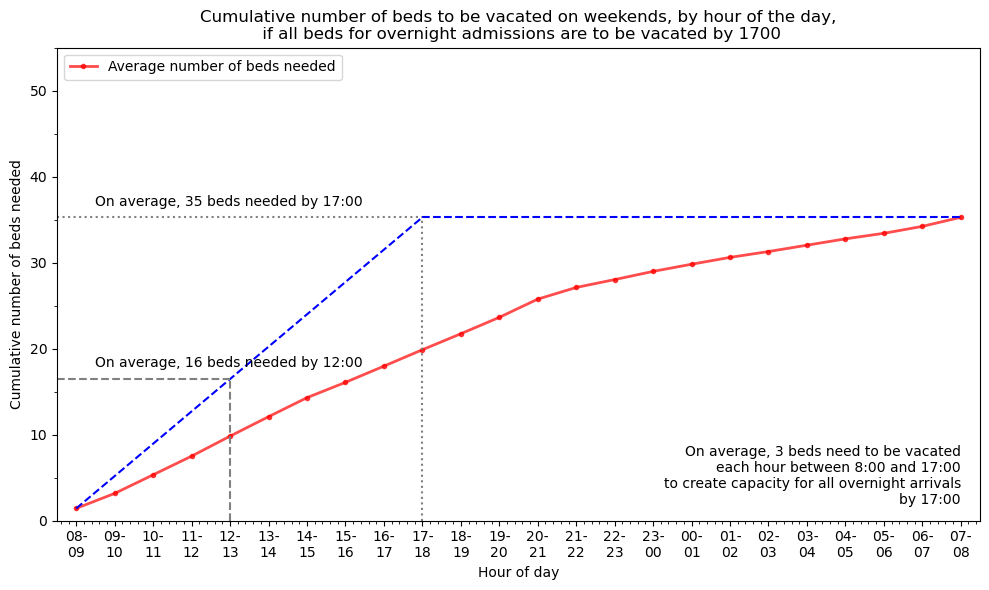

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


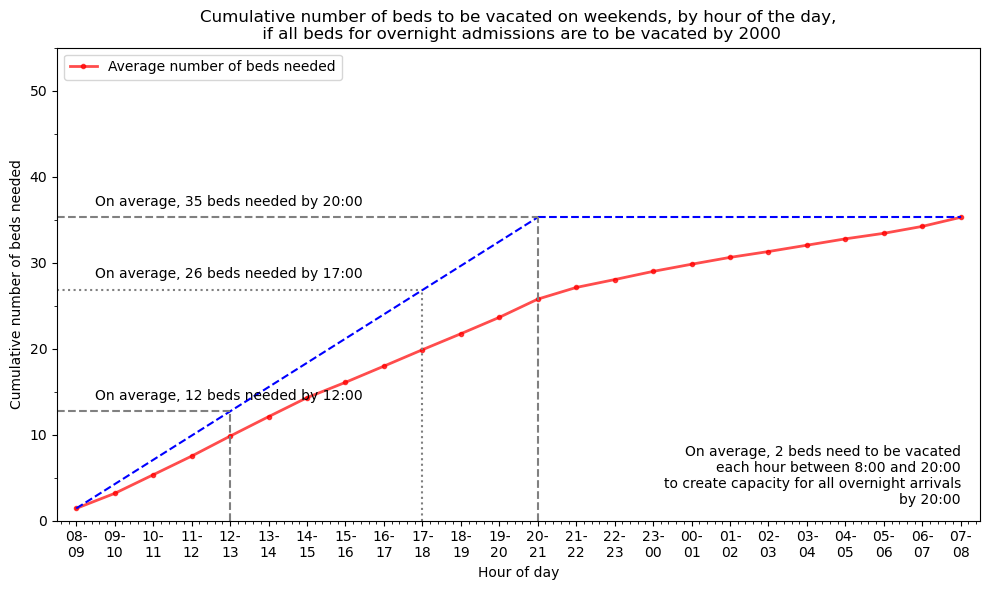

In [27]:
from patientflow.viz.arrival_rates import plot_cumulative_arrival_rates
def plot_average_beds_needed(scenarios):
    """
    Generate bed occupancy plots for both weekday and weekend data.
    """
    
    for scenario in scenarios:
        # First plot: 4-hour admission delay
        title = f'Cumulative number of beds needed on {scenario["label"]}, by hour of the day,\n if each incoming patient is admitted exactly four hours after arrival, starting at 8 am'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            start_plot_index=8,
            media_file_path=scenario["file_path"],
            file_prefix='3_'
        )
        
        # Second plot: 17:00 vacancy requirement
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day,\n if all beds for overnight admissions are to be vacated by {17}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 17),
            media_file_path=scenario["file_path"],
            file_prefix='4_',
            set_y_lim=55
        )
        
        # Second plot: 20:00 vacancy requirement
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day,\n if all beds for overnight admissions are to be vacated by {20}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 20),
            media_file_path=scenario["file_path"],
            file_prefix='4_',
            set_y_lim=55,
            hour_lines=[12,17,20]
        )


# List of scenarios to process
scenarios = [
    {
        'data': weekdays,
        'file_path': media_file_path_weekdays,
        'label': 'weekdays'
    },
    {
        'data': weekends,
        'file_path': media_file_path_weekends,
        'label': 'weekends'
    }
]

plot_average_beds_needed(
    scenarios,
)


## Plot aspirational curve

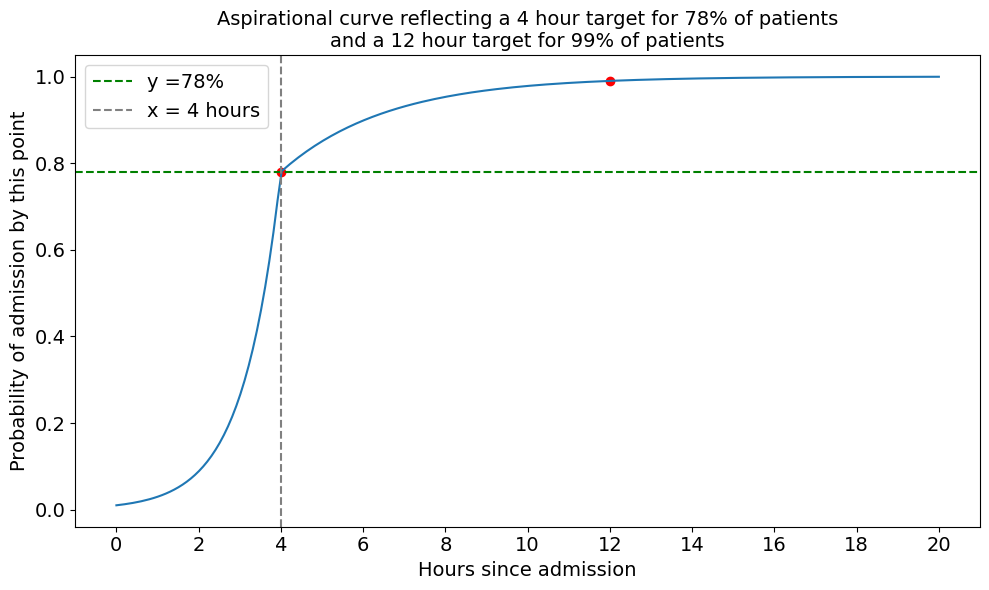

In [22]:
import matplotlib.pyplot as plt
from patientflow.viz.aspirational_curve_plot import plot_curve

figsize = (6,3)
title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients'

plot_curve(
    title = title,
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    figsize = (10,6),
    include_titles=True,
    text_size=14,
    media_file_path=media_file_path_weekends,
    file_name=title.replace(" ", "_"),
)


## Plot true demand per hour against arrival rates 

Calculating time-varying arrival rates for data provided, which spans 543 unique dates
Calculating time-varying arrival rates for data provided, which spans 543 unique dates
Calculating time-varying arrival rates for data provided, which spans 216 unique dates
Calculating time-varying arrival rates for data provided, which spans 216 unique dates


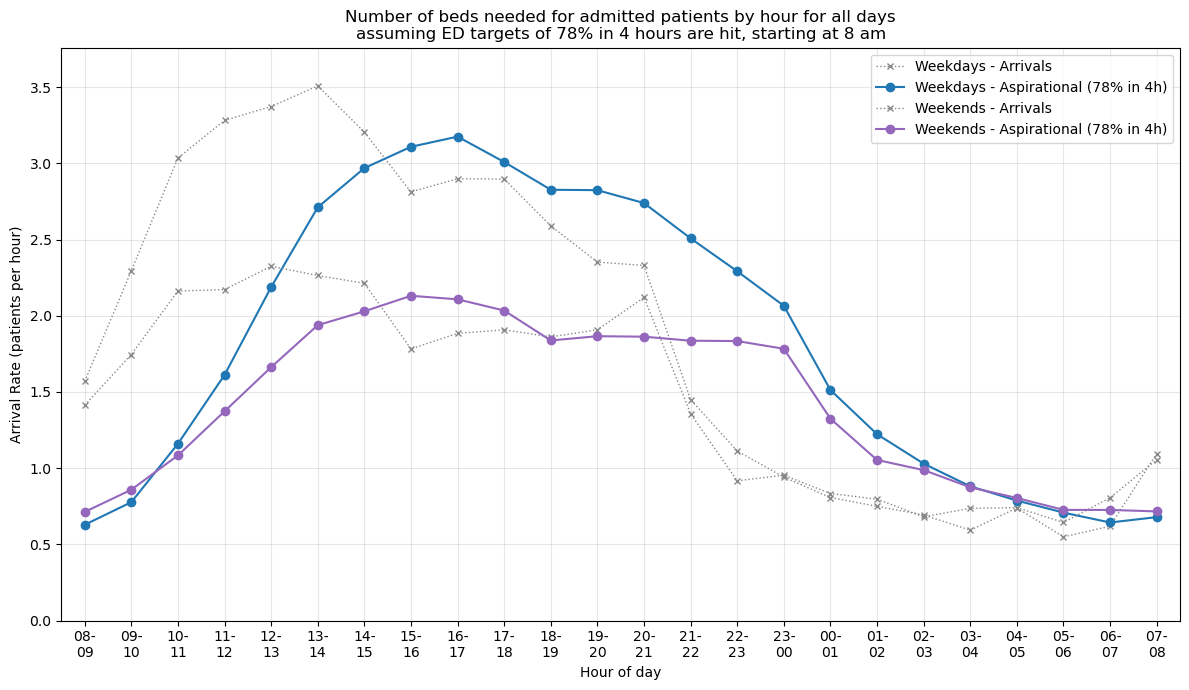

In [58]:

title = f'Number of beds needed for admitted patients by hour on weekdays\nassuming ED targets of {int(y1*100)}% in {int(x1)} hours are hit, starting at 8 am'

# plot_arrival_rates(weekdays, title, start_plot_index = 8, 
#                    lagged_by=4, 
#                    curve_params=(x1, y1, x2, y2), 
#                    file_prefix = '5_',
#                    media_file_path=media_file_path_weekdays)


# title = f'Number of beds needed for admitted patients by hour on weekends\nassuming ED targets of {int(y1*100)}% in {int(x1)} hours are hit, starting at 8 am'

# plot_arrival_rates(weekends, title, start_plot_index = 8, 
#                    lagged_by=4, 
#                    curve_params=(x1, y1, x2, y2), 
#                    file_prefix = '5_',
#                     media_file_path=media_file_path_weekends)



# plot for both
title = f'Number of beds needed for admitted patients by hour for all days\nassuming ED targets of {int(y1*100)}% in {int(x1)} hours are hit, starting at 8 am'
plot_dual_arrival_rates(inpatient_arrivals_1=weekdays,
                        inpatient_arrivals_2=weekends, 
                    labels=('Weekdays', 'Weekends'),
                   title=title, 
                   # lagged_by=4, 
                   curve_params=(x1, y1, x2, y2), 
                    start_plot_index=start_plot_index, 
                   file_prefix = '5_',
                   media_file_path=media_file_path_weekends
                   )

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


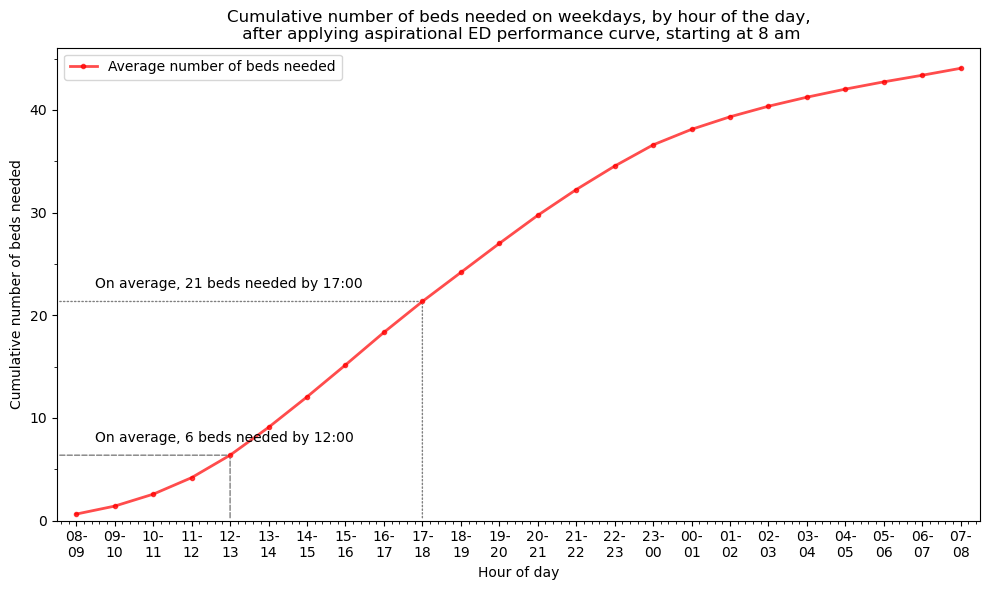

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


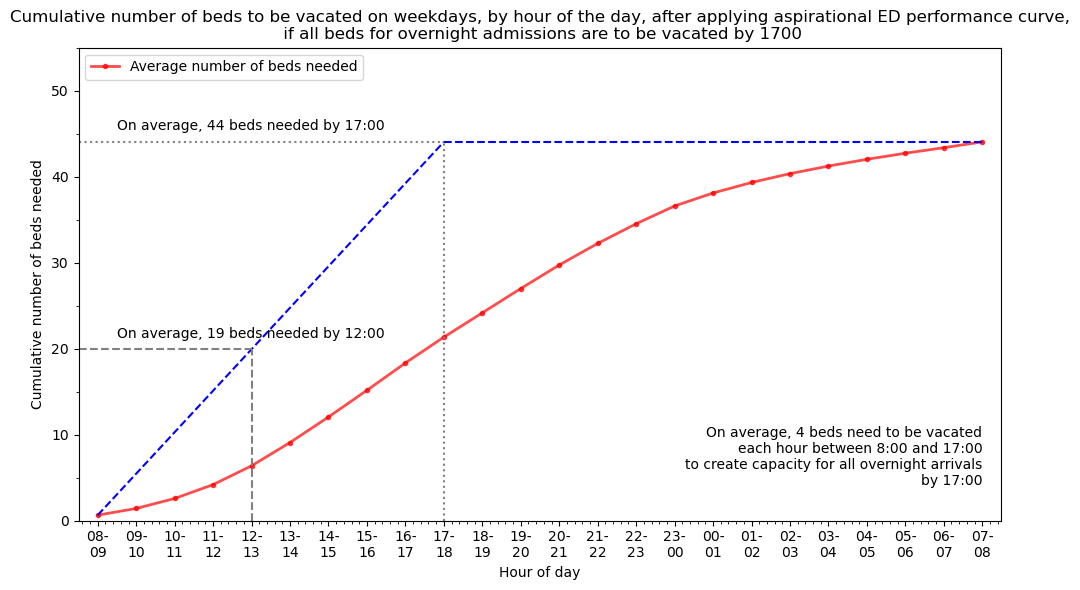

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


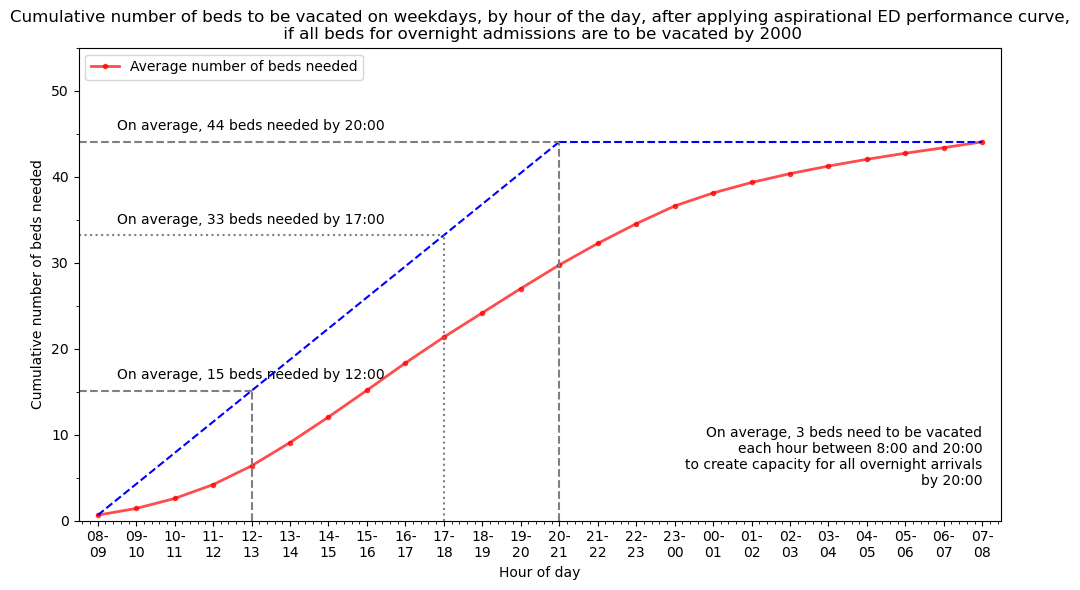

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


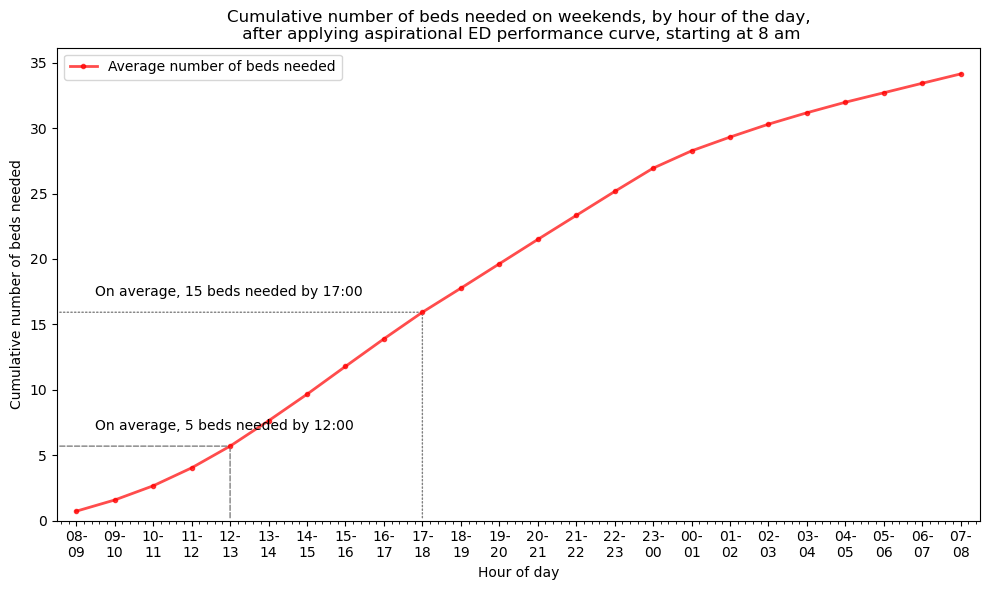

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


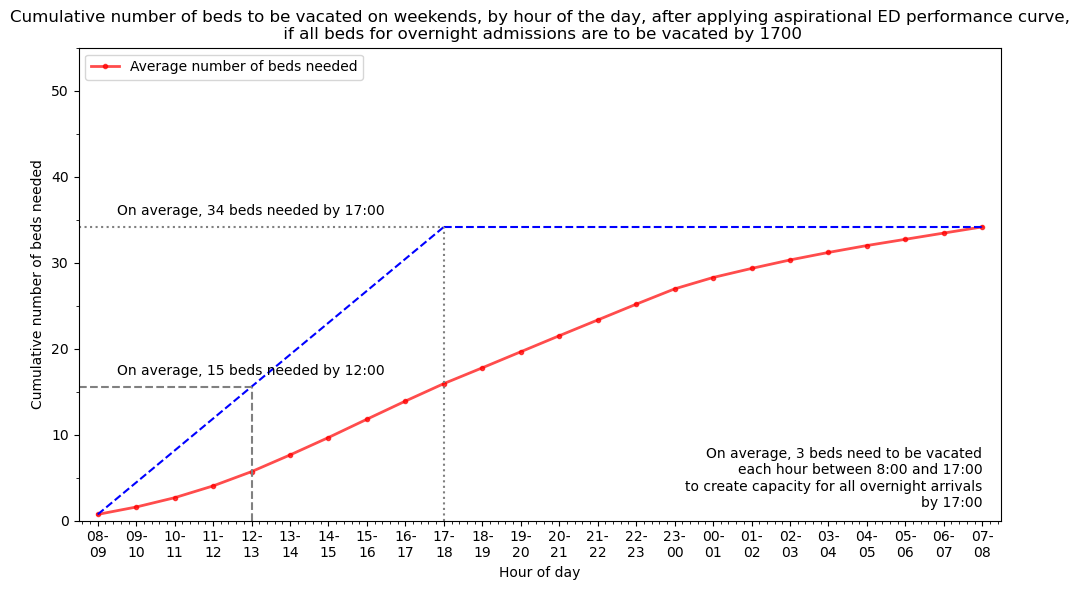

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


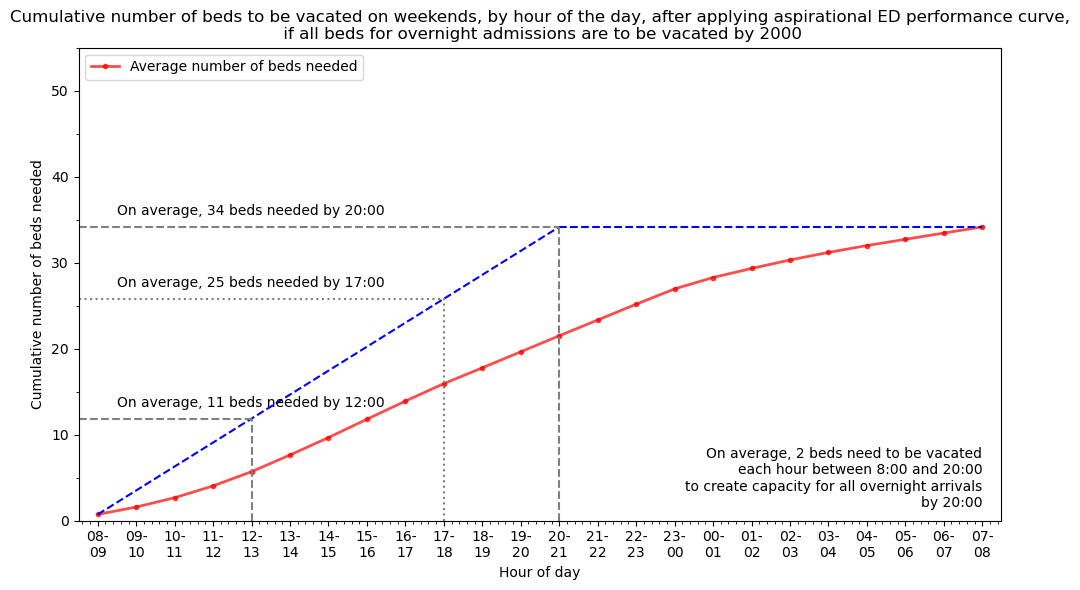

In [28]:
def plot_average_beds_needed_using_aspirational_curve(scenarios):
    """
    Generate bed occupancy plots for both weekday and weekend data, after applying aspirational curve.
    """
    
    for scenario in scenarios:
        # First plot: 4-hour admission delay
        title = f'Cumulative number of beds needed on {scenario["label"]}, by hour of the day,\n after applying aspirational ED performance curve, starting at 8 am'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            curve_params=(x1, y1, x2, y2),
            start_plot_index=8,
            media_file_path=scenario["file_path"],
            file_prefix='6_'
        )
        
        # Second plot: 17:00 vacancy requirement
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day, after applying aspirational ED performance curve,\n if all beds for overnight admissions are to be vacated by {17}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            curve_params=(x1, y1, x2, y2),
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 17),
            media_file_path=scenario["file_path"],
            file_prefix='7_',
            set_y_lim=55
        )
        
        # Second plot: 20:00 vacancy requirement
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day, after applying aspirational ED performance curve,\n if all beds for overnight admissions are to be vacated by {20}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            curve_params=(x1, y1, x2, y2),
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 20),
            media_file_path=scenario["file_path"],
            file_prefix='7_',
            set_y_lim=55,
            hour_lines=[12,17,20]
        )

plot_average_beds_needed_using_aspirational_curve(scenarios)

## Cumulative plot with probabilities

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


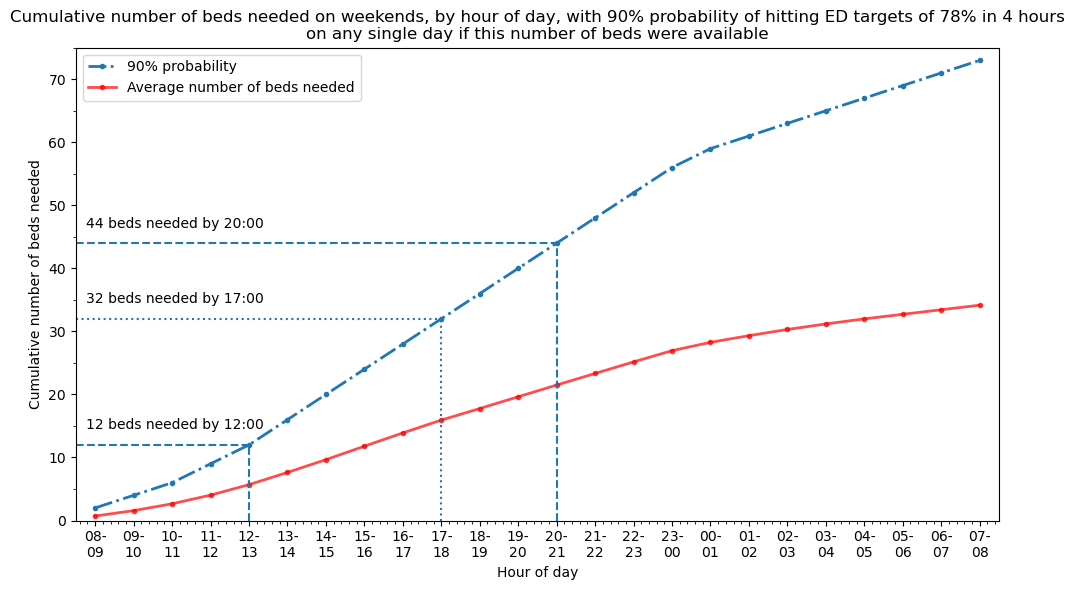

In [63]:
# title = f'Cumulative number of beds needed on weekdays, by hour of day, with probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
# plot_cumulative_arrival_rates(
#    weekdays,
#     title,
#     curve_params=(x1, y1, x2, y2),
#     lagged_by=None,
#     time_interval=60,
#     start_plot_index=8,
#     draw_window=None,
#     x_margin=0.5,
#     file_prefix='9_',
#     set_y_lim=None,
#     hour_lines=[12, 17],
#     line_styles={12: '--', 17: ':'},
#     annotation_prefix='On average',
#     line_colour='red',
#     plot_centiles=True,
#     highlight_centile=0.9,
#     centiles=[0.3, 0.5, 0.7, 0.9, 0.99],
#     markers=['D', 's', '^', 'o', 'v'],
#     line_styles_centiles=['-.', '--', ':', '-', '-'],
#     bed_type_spec='',
#     media_file_path=media_file_path_weekdays

# )

# title = f'Cumulative number of beds needed on weekends, by hour of day, with probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
# plot_cumulative_arrival_rates(
#    weekends,
#     title,
#     curve_params=(x1, y1, x2, y2),
#     lagged_by=None,
#     time_interval=60,
#     start_plot_index=8,
#     draw_window=None,
#     x_margin=0.5,
#     file_prefix='9_',
#     set_y_lim=None,
#     hour_lines=[12, 17],
#     line_styles={12: '--', 17: ':'},
#     annotation_prefix='On average',
#     line_colour='red',
#     plot_centiles=True,
#     highlight_centile=0.9,
#     centiles=[0.3, 0.5, 0.7, 0.9, 0.99],
#     markers=['D', 's', '^', 'o', 'v'],
#     line_styles_centiles=['-.', '--', ':', '-', '-'],
#     bed_type_spec='',
#     media_file_path=media_file_path_weekends


# )

# plot showing just 90% centile for weekends
title = f'Cumulative number of beds needed on weekends, by hour of day, with 90% probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
plot_cumulative_arrival_rates(
   weekends,
    title,
    curve_params=(x1, y1, x2, y2),
    lagged_by=None,
    time_interval=60,
    start_plot_index=8,
    draw_window=None,
    x_margin=0.5,
    file_prefix='9_',
    set_y_lim=None,
    hour_lines=[12,17,20],
    annotation_prefix='On average',
    line_colour='red',
    plot_centiles=True,
    highlight_centile=0.9,
    centiles=[ 0.9],
    markers=['o'],
    line_styles_centiles=['-.', '--', ':', '-', '-'],
    bed_type_spec='',
    media_file_path=media_file_path_weekends


)

## Plot by specialty

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


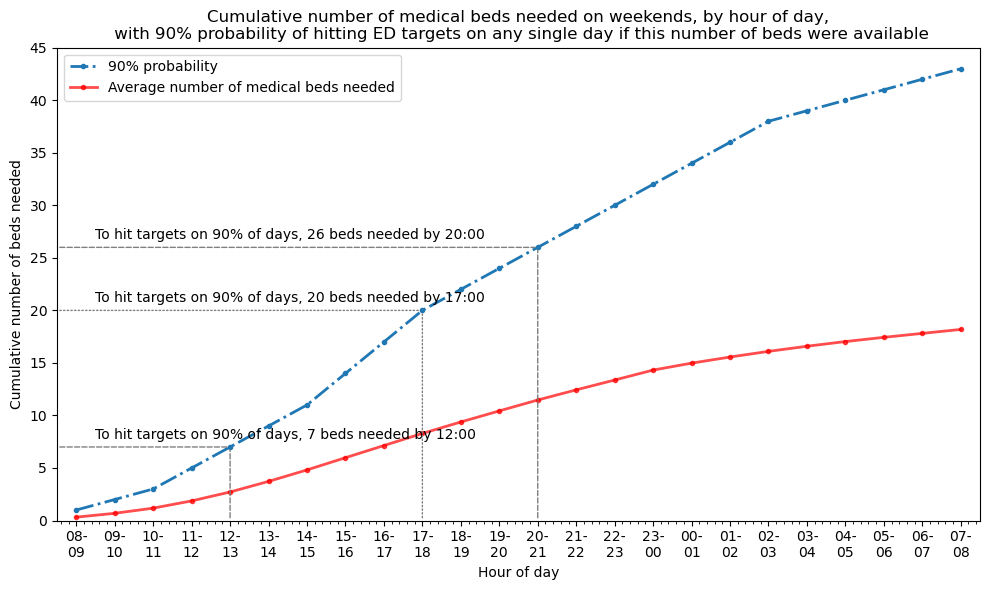

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


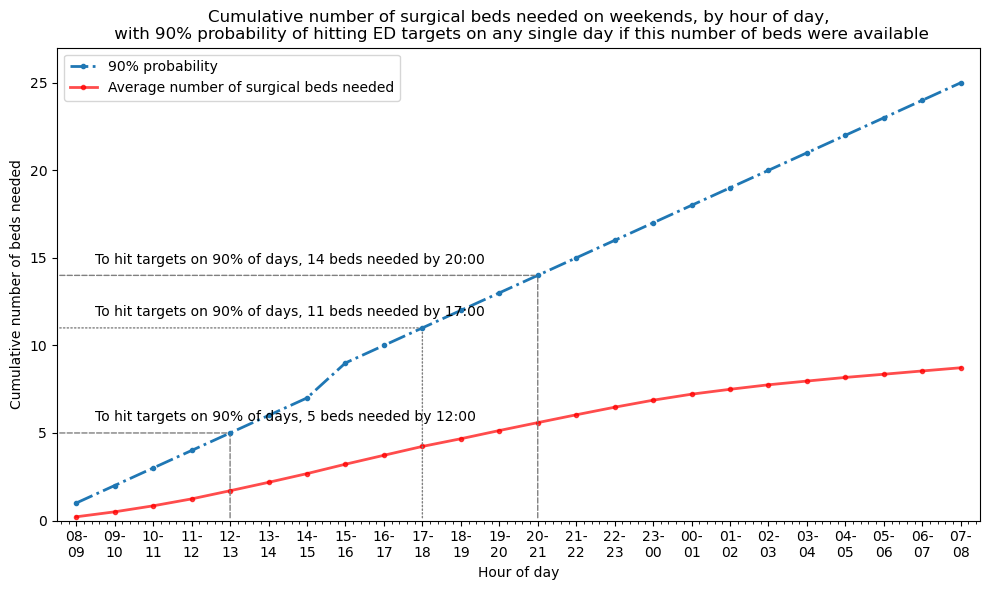

Calculating time-varying arrival rates for data provided, which spans 208 unique dates


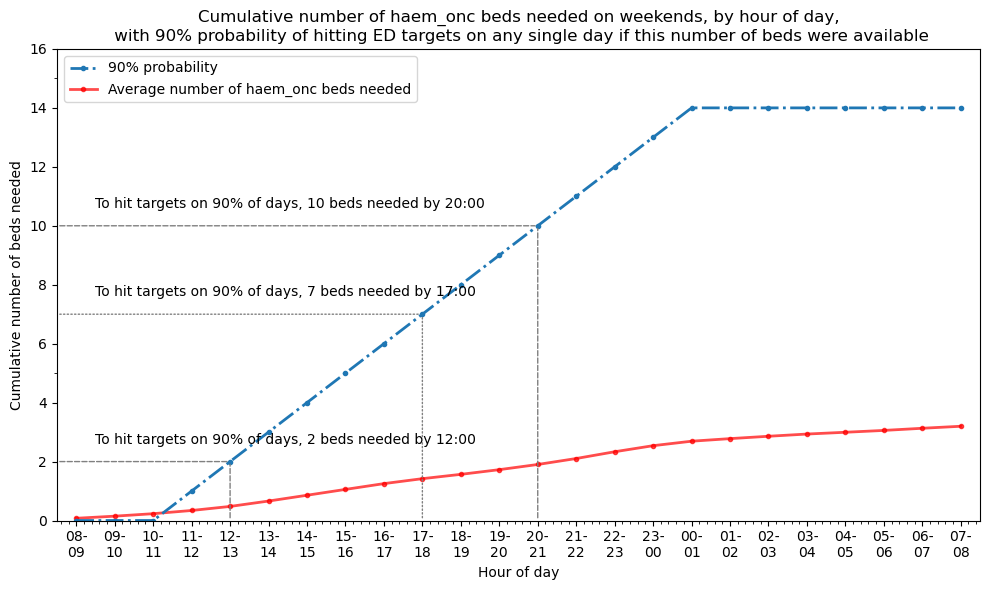

Calculating time-varying arrival rates for data provided, which spans 207 unique dates


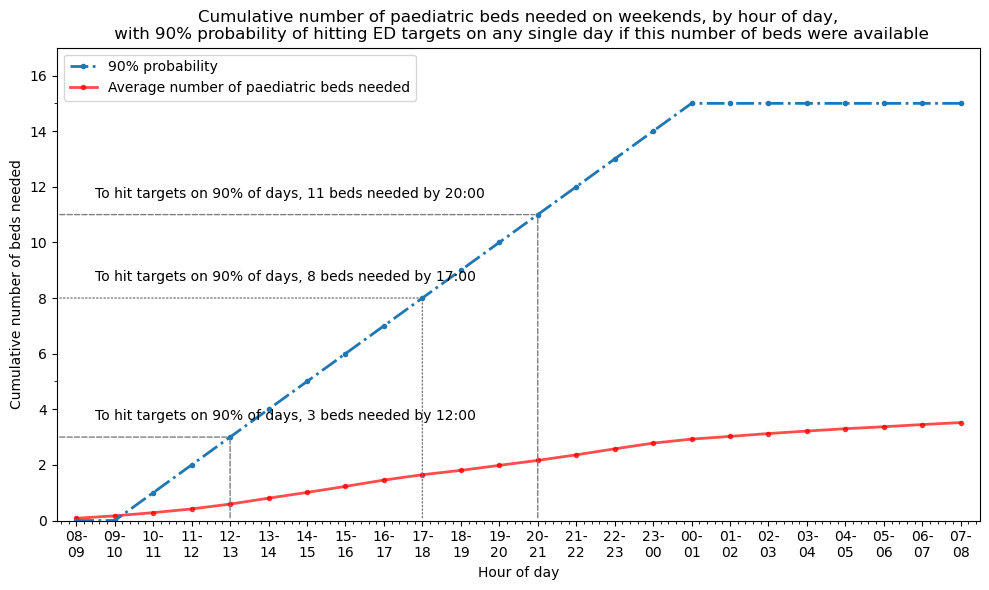

In [24]:
from patientflow.viz.arrival_rates import plot_cumulative_arrival_rates

for _spec in ['medical', 'surgical', 'haem/onc', 'paediatric']:
    inpatient_arrivals_spec = weekends[(~weekends.specialty.isnull()) & (weekends.specialty == _spec)]
    __spec = _spec.replace('/', '_')
    
    title = f'Cumulative number of {__spec} beds needed on weekends, by hour of day,\n with 90% probability of hitting ED targets on any single day if this number of beds were available'

    plot_cumulative_arrival_rates(
    inpatient_arrivals_spec,
        title,
        curve_params=(x1, y1, x2, y2),
        lagged_by=None,
        time_interval=60,
        start_plot_index=8,
        draw_window=None,
        x_margin=0.5,
        file_prefix='A_',
        set_y_lim=None,
        hour_lines=[12,17,20],
        annotation_prefix='To hit targets on 90% of days',
        line_colour='red',
        plot_centiles=True,
        highlight_centile=0.9,
        centiles=[0.9],
        markers=['o'],
        line_styles_centiles=['-.', '--', ':', '-', '-'],
        bed_type_spec=__spec,

        text_y_offset=0.5,
        media_file_path=media_file_path_weekends


    )
    


### Including influencable window

NOTE - currently you can only draw window or plot centiles